# IEOR 265 HW1

Abigail Chaver and Pelagie Elimbi

April 6, 2018

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
wine = pd.read_csv("http://ieor.berkeley.edu/~ieor265/homeworks/winequality-red.csv", sep=";")

In [375]:
# Split data for estimating error
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    wine.drop(['quality'], axis=1), wine.quality, 
    test_size=0.33, random_state=401)

## OLS

In [376]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
regr_pred = regr.predict(X_test)

In [377]:
# Errors
print("OLS Mean squared error: %.2f"
      % mean_squared_error(y_test, regr_pred))
print('OLS R-squared: %.2f' % r2_score(y_test, regr_pred))

OLS Mean squared error: 0.41
OLS R-squared: 0.37


## Ridge Regression

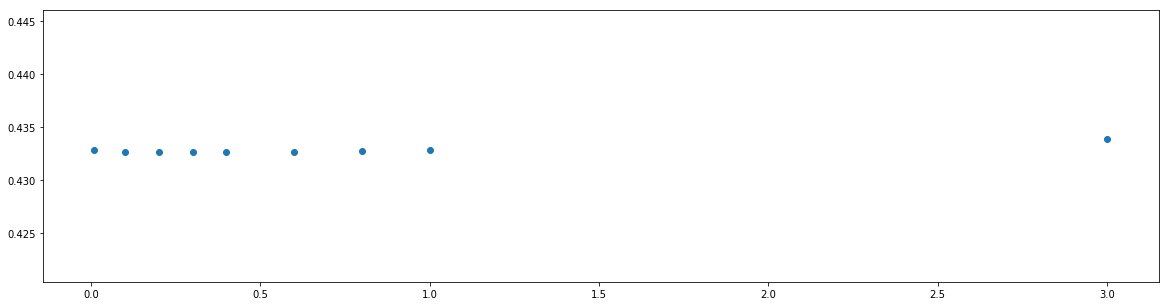

In [380]:
alphas = (0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0, 3)
rr = linear_model.RidgeCV(alphas, store_cv_values = True )
rr.fit(X_train, y_train)
plt.figure(figsize=(20,5))
plt.scatter(alphas, list(pd.DataFrame(rr.cv_values_).mean()))

In [379]:
# Optimal Alpha
rr.alpha_

0.40000000000000002

In [381]:
rr_pred = rr.predict(X_test)
print("Ridge Regression Mean squared error: %.2f"
      % mean_squared_error(y_test, rr_pred))
print('Ridge Regression R-squared: %.2f' % r2_score(y_test, regr_pred))

Ridge Regression Mean squared error: 0.41
Ridge Regression R-squared: 0.37


## Lasso 

In [382]:
lasso = linear_model.LassoCV()
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

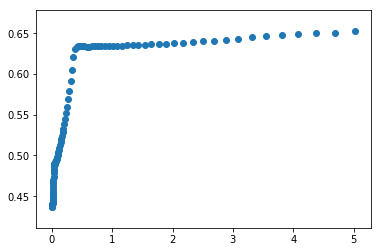

In [383]:
plt.scatter(lasso.alphas_, 
            pd.DataFrame(lasso.mse_path_).apply(np.mean, axis=1))

In [384]:
lasso.alpha_

0.0050322499370118404

In [385]:
l_pred = lasso.predict(X_test)
print("Ridge Regression Mean squared error: %.2f"
      % mean_squared_error(y_test, l_pred))
print('Ridge Regression R-squared: %.2f' % r2_score(y_test, l_pred))

Ridge Regression Mean squared error: 0.42
Ridge Regression R-squared: 0.35


## EDE

In [386]:
# Split training data to choose tuning parameters by hand
eX_train, eX_test, ey_train, ey_test = train_test_split(
    X_train, y_train, 
    test_size=0.33, random_state=301)

In [387]:
u, s, vh = np.linalg.svd(eX_train)

In [388]:
def get_prod(d):
    v2 = vh[:, d+1: 11:1]
    prod = np.matmul(v2, np.transpose(v2))
    return(prod)

In [169]:
from scipy.optimize import minimize

In [389]:
def score_ede(mu, d):
    prod = get_prod(d)
    
    def ede(bvec):
        # Compute objective function
        colOne = np.array(np.ones(len(eX_train) + 11))
        colOne[-11:] = 0
        colX = np.concatenate((np.array(eX_train), mu*prod), axis=0)
        data = np.concatenate((np.transpose(np.matrix(colOne)), colX), 
                              axis=1)
        Y0 = np.matrix(np.concatenate((np.array(ey_train),np.zeros(11)), 
                                      axis=0))
        val = Y0 - np.matmul(data, bvec)
        L2 = np.linalg.norm(val)
        return L2
    # initialize optimizer with all zero coefficients
    beta = np.zeros(12)
    z = minimize(ede, beta)
    # Get predicted values
    bvec_A = z.x[1:]
    b0 = z.x[0]
    ede_pred = eX_test.apply(lambda a : b0 + np.matmul(a, bvec_A), axis=1)
    return(mean_squared_error(ey_test, ede_pred))
    

In [403]:
# Grid search for best combination
mus=[0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 8]
ede_mse=pd.DataFrame(index=mus, columns=range(9))
for i in range(9):
    for j in range(len(mus)):
        mu = mus[j]
        ede_mse.iloc[j, i] =score_ede(mu,i)
ede_mse

,0,1,2,3,4,5,6,7,8
0.01,0.447169,0.447368,0.447454,0.447455,0.447456,0.447457,0.447456,0.44746,0.447541
0.10,0.44422,0.444286,0.444292,0.444275,0.44427,0.444291,0.444294,0.4443,0.444332
0.50,0.443925,0.443989,0.44403,0.443543,0.443484,0.443957,0.444047,0.444061,0.44406
1.00,0.443588,0.443751,0.443999,0.442202,0.441984,0.443503,0.443854,0.443896,0.443887
2.00,0.442026,0.442406,0.443505,0.439858,0.438988,0.441951,0.443223,0.443363,0.443325
3.00,0.441025,0.441449,0.443686,0.439359,0.437306,0.44003,0.44251,0.442749,0.442669
4.00,0.440976,0.441316,0.444616,0.440121,0.436534,0.438288,0.44201,0.442245,0.442127
5.00,0.441584,0.441806,0.445886,0.441458,0.436362,0.437073,0.441927,0.441933,0.441797
6.00,0.442634,0.442751,0.447272,0.442993,0.43673,0.436545,0.442365,0.441806,0.441675
8.00,0.445456,0.445444,0.450021,0.446029,0.43903,0.437627,0.444883,0.441954,0.441854


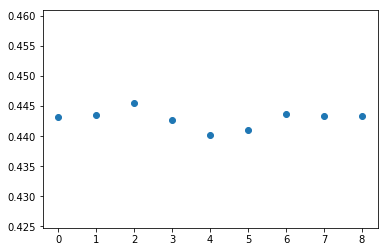

In [404]:
# Compare values of d
plt.scatter(range(9), ede_mse.mean())

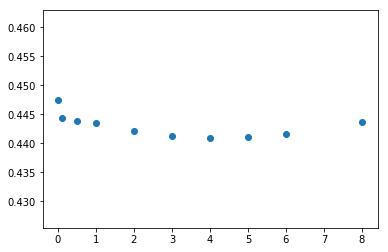

In [405]:
# Compare values of mu
plt.scatter(mus, ede_mse.mean(axis=1))

In [414]:
# Let mu = 4 and d = 4
# Compute beta vector with full test set

def final_ede(bvec):
    d = 4
    mu = 4
    prod = get_prod(d)
    colOne = np.array(np.ones(len(X_train) + 11))
    colOne[-11:] = 0
    colX = np.concatenate((np.array(X_train), mu*prod), axis=0)
    data = np.concatenate((np.transpose(np.matrix(colOne)), colX), axis=1)
    Y0 = np.matrix(np.concatenate((np.array(y_train),np.zeros(11)), axis=0))
    val = Y0 - np.matmul(data, bvec)
    L2 = np.linalg.norm(val)
    return L2
    
beta = np.zeros(12)
z = minimize(final_ede, beta)
bvec_F = z.x[1:]
b0 = z.x[0]
ede_predF = X_test.apply(lambda a : b0 + np.matmul(a, bvec_F), axis=1)

In [415]:
print("Ridge Regression Mean squared error: %.2f"
      % mean_squared_error(y_test, ede_predF))
print('Ridge Regression R-squared: %.2f' % r2_score(y_test, ede_predF))

Ridge Regression Mean squared error: 0.42
Ridge Regression R-squared: 0.36


## Summary

In [416]:
Coef_Index=pd.Index( X_train.columns.insert(item="Intercept", loc= 11))
Coef= pd.DataFrame( {'OLS Coefficients': regr.coef_,
                'Ridge Coefficients': rr.coef_,
              'Lasso Coefficients':lasso.coef_,
              'EDE Coefficients': bvec_F})

Coef= Coef.append({'OLS Coefficients': regr.intercept_,
                'Ridge Coefficients': rr.intercept_,
              'Lasso Coefficients':lasso.intercept_,
              'EDE Coefficients': b0}, ignore_index=True)
Coef.index = Coef_Index
Coef

,EDE Coefficients,Lasso Coefficients,OLS Coefficients,Ridge Coefficients
fixed acidity,-0.010281,0.020587,0.003466,0.008702
volatile acidity,-0.633857,-0.869663,-1.014967,-1.019452
citric acid,0.093790,-0.000000,-0.245508,-0.252408
residual sugar,0.004202,0.000000,0.006665,0.006826
chlorides,-2.156749,-0.000000,-1.692493,-1.342199
free sulfur dioxide,0.006457,0.005218,0.005014,0.004960
total sulfur dioxide,-0.004457,-0.003657,-0.003823,-0.003753
density,-0.083187,-0.000000,2.854123,0.000180
pH,-0.540391,-0.000000,-0.502845,-0.451275
sulphates,0.857768,0.590575,0.882159,0.846102


#### Error Comparison
Similar performance on all models.

In [418]:
pd.Series({"OLS Error": mean_squared_error(y_test, regr_pred),
                   "Ridge Error": mean_squared_error(y_test, rr_pred),
                "Lasso Error": mean_squared_error(y_test, l_pred),
                "EDE Error": mean_squared_error(y_test, ede_predF)})

EDE Error      0.415389
Lasso Error    0.423734
OLS Error      0.410529
Ridge Error    0.411378
dtype: float64